# In this notebook we will map rsfMRI data to a hippocampal surface, and then visualize it

NOTE: this tutorial assumes you have tools like `FSL`, `ANTs`, `AFNI`, `NiftyReg`, and `wb_command` already in your bash `PATH`.

We will assume HippUnfold was run on the native T1w image.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import nibabel as nib
import sys
import hippomaps as hm

In [36]:
# set up a test subject
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

subject = 'HC002'
session = '01'
hemis = ['L','R']
labels = ['hipp','dentate'] #the dentate gyrus is given a separate surface. Here we will include it but this is optional.

!mkdir -p tmp # make a temporary directory for storing files

## 0) Resample data to the same space
In most cases, preprocessing should put your fMRI data into alignment with the T1w image, and therefore with HippUnfold outputs. If that is the case, skip to step 1).

In Micapipe, fMRI data are kept in their native space to avoid interpolation that comes with transforming it to `space-T1w` (Or in Micapipe, `space-nativepro`). Find the right transform(s) for your data in the Micapipe `xfm` directory. Below is an example. 

It is best to ensure that these registrations are correct before proceeding! I find the best way to do this is open a HippUnfold surface in Freeview and then add the resampled images to visually ensure they are aligned.

In [2]:
# depending on the type of data (rsfMRI, task-fMRI, DWI, or other), 
# you'll need to find the correct transform(s)
aff = f'{micapipe_dir}/sub-{subject}/ses-{session}/xfm/sub-{subject}_ses-{session}'\
    f'_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat'
!ls {aff}

# convert the affine format
cmd = f'c3d_affine_tool '\
    f'-itk {aff} '\
    f'-inv '\
    f'-o tmp/aff.txt'
!{cmd}
aff = f'tmp/aff.txt'

warp = f'{micapipe_dir}/sub-{subject}/ses-{session}/xfm/sub-{subject}_ses-{session}'\
    f'_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1InverseWarp.nii.gz'
!ls {warp}

rsfMRI = f'{micapipe_dir}/sub-{subject}/ses-{session}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{subject}_ses-{session}'\
    f'_space-func_desc-se_preproc.nii.gz'
!ls {rsfMRI}

/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC002/ses-01/xfm/sub-HC002_ses-01_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat
/bin/bash: c3d_affine_tool: command not found
/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC002/ses-01/xfm/sub-HC002_ses-01_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1InverseWarp.nii.gz
/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC002/ses-01/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-HC002_ses-01_space-func_desc-se_preproc.nii.gz


In [3]:
for h in range(len(hemis)):
    for l in range(len(labels)):
        cmd1 = f'wb_command -surface-apply-affine '\
            f'{hippunfold_dir}/sub-{subject}/ses-{session}/surf/sub-{subject}_ses-{session}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'{aff} '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-funcaff_den-2mm_label-{label[l]}_midthickness.surf.gii'
        !{cmd1}
        cmd2 = f'wb_command -surface-apply-warpfield '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-funcaff_den-2mm_label-{label[l]}_midthickness.surf.gii ' \
            f'{warp} '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-funcwarp_den-2mm_label-{label[l]}_midthickness.surf.gii'
        !{cmd2}

## 1) Sample data along a hippocampal surface:

For fMRI data, resolution is typically >=2mm, and so I recommend using `den-2mm` surfaces (obtained by adding the flag `--output_density 2mm ` when executing HippUnfold). Otherwise the default `den-0p5mm` surfaces will work fine, but you may be unnecessarily oversampling the fMRI data.

In [4]:
for h in range(len(hemis)):
    for l in range(len(labels)):
        cmd = f'wb_command -volume-to-surface-mapping '\
            f'{rsfMRI} '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-funcwarp_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii '\
            f'-enclosing'
        !{cmd}

## 2) (optional) Smooth data along hippocampal surface:

Most of the time fMRI data benefits from smoothing. This is best done along a surface so values are not combined across a suclus (or across hippocampal folds).

Note that depending on your data resolution you may want to adjust the size of the smoothing kernel, but remmeber that the hippocampus is only ~10mm wide in some regions!

In [3]:
sigma = 2 #Gaussian smoothing kernal sigma (mm)

for h in range(len(hemis)):
    for l in range(len(labels)):
        cmd = f'wb_command -metric-smoothing '\
            f'{hippunfold_dir}/sub-{subject}/ses-{session}/surf/sub-{subject}_ses-{session}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii '\
            f'{sigma} '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri_smooth.func.gii'
        !{cmd}

## 3) Load and plot surface data with matplotlib

Here, we will only load one hemisphere and one surface (ie. no dentate gyrus). This is to showcase some of the plotting tools in the HippUnfold_toolbox and to illustrate how surface data is formatted.

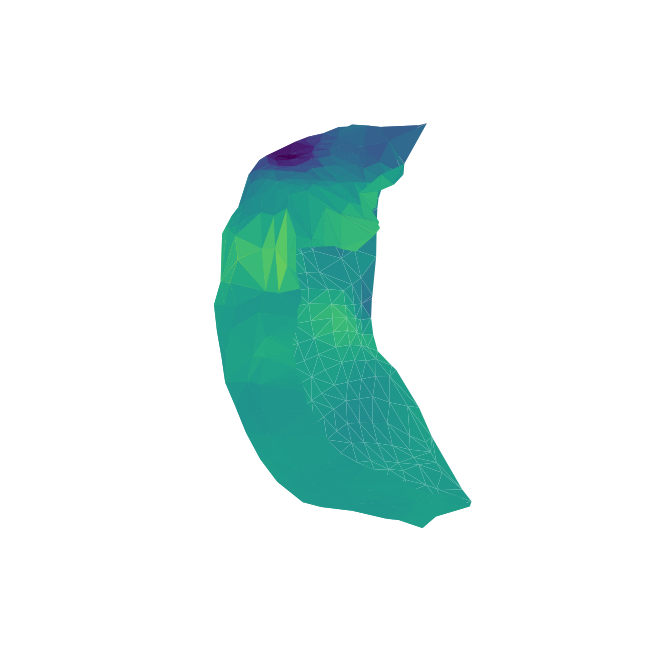

In [28]:
surface = nib.load(f'{hippunfold_dir}/sub-{subject}/ses-{session}/surf/sub-{subject}_ses-{session}_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
vertices = surface.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
faces = surface.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
func = nib.load(f'tmp/sub-{subject}_hemi-L_space-T1w_den-2mm_label-hipp_desc-rsmfri_smooth.func.gii')

# plot only the very first timepoint
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36,12), subplot_kw={'projection': "3d"})
ax.view_init(elev=90, azim=-90)

# convert vertex-wise data to face-wise 
c = func.darrays[0].data
cf = np.zeros([len(faces)])
for f in range(len(faces)):
    cf[f] = np.mean(c[faces[f]],axis=0)
norm = plt.Normalize(np.min(cf), np.max(cf)) 
colors = plt.cm.viridis(norm(cf))

# now plot
pc = art3d.Poly3DCollection(vertices[faces], facecolors=colors)
ax.add_collection(pc)
ax.set_xlim([np.min(vertices[:,0]),np.max(vertices[:,0])])
ax.set_ylim([np.min(vertices[:,1]),np.max(vertices[:,1])])
ax.set_zlim([np.min(vertices[:,2]),np.max(vertices[:,2])])
ax.view_init(elev=90, azim=-90)

# set axes equal
x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()

x_range = abs(x_limits[1] - x_limits[0])
x_middle = np.mean(x_limits)
y_range = abs(y_limits[1] - y_limits[0])
y_middle = np.mean(y_limits)
z_range = abs(z_limits[1] - z_limits[0])
z_middle = np.mean(z_limits)

# The plot bounding box is a sphere in the sense of the infinity
# norm, hence I call half the max range the plot radius.
plot_radius = 0.5*max([x_range, y_range, z_range])

ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

ax.set_axis_off()  

## 4) Make a nice figure

This function will use generic surface (ie. not subject-specific) to plot L+R, dentate+hipp, and folded+unfolded surfaces.

In [48]:
# load the hippocampal functional data
func.darrays[0].data
shp = [419,64]
ind = [range(419), range(419,483)]

cdata_hipp = np.ones((np.sum(shp),2,len(func.darrays)))*np.nan
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        func = nib.load(f'tmp/sub-{subject}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_desc-rsmfri_smooth.func.gii')
        for c in range(len(func.darrays)):
            cdata_hipp[ind[l],h,c] = func.darrays[c].data

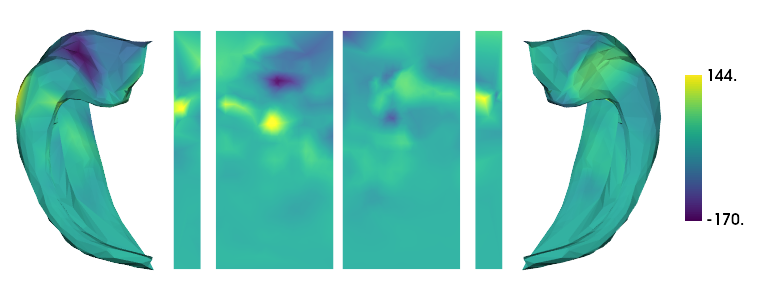

In [51]:
hm.plotting.surfplot_canonical_foldunfold(cdata_hipp[:,:,0], den='2mm', unfoldAPrescale=True, share='row', color_bar='right', embed_nb=True)

Let's have some fun and turn this data into a gif file:

In [ ]:
# make a gif
import imageio
with imageio.get_writer('Hippo_ts.gif', mode='I') as writer:
    for t in range(cdata_hipp.shape[2]):
        hm.plotting.surfplot_canonical_foldunfold(cdata_hipp[:,:,t], den='2mm', color_range=(-100,100), embed_nb=False, screenshot=True, filename=f'tmp/frame_{t}.png')
        image = imageio.imread(f'tmp/frame_{t}.png')
        writer.append_data(image)
!rm tmp/frame_*.png

## Scaling up

This code can be looped over all subjects, and can be run on different features. For example, instead of an fMRI image, we could transform and sample a DWI image. 

All hippunfold subjects have corresponding vertices, meaning that we could load and average across subjects WHERE APPROPRIATE - we wouldn't do this for rsfMRI since subjects may be thinking of different things at different times. We could consider doing this for a time-locked experiment like movie watching, or, we could average across subjects for each vertex for a structural measure like Fractional Anisotropy (FA) derived from DWI. 

We could consider running an expierment where we compare FA measures across two groups at each vertex. This is more precise than other methods since vertices are carefully aligned between subjects according to their topology in HippUnfold. We could also find the subset of vertices belonging to a given subfield using (for example) the `sub-HC002_hemi-L_space-T1w_den-0p5mm_label-hipp_subfields.label.gii` HippUnfold output file. Averaging data within one of these ROIs may help improve signal-to-noise ratio, at the cost of no longer being able to check for anterior-posterior differences. Alternatively, we could parametrically test whether data aligns with the anterior-posterior axis by correlating it with the unfolded y axis. 